<a href="https://github.com/niva83/YADDUM"><img style="float: left;" src="https://img.shields.io/github/v/release/niva83/YADDUM"></a>
 <a href="https://zenodo.org/badge/latestdoi/221973907"><img style="float: left;" src="https://zenodo.org/badge/221973907.svg"></a><a href="https://zenodo.org/badge/latestdoi/221973907"></a> 
<a href="https://github.com/niva83/YADDUM/blob/master/LICENSE"><img style="float: left;" src="https://img.shields.io/badge/license-BSD-green"></a>
 <a href="https://www.buymeacoffee.com/z57lyJbHo" rel="nofollow"><img style="float: left;" alt="https://img.shields.io/badge/Donate-Buy%20me%20a%20coffee-yellowgreen.svg" src="https://img.shields.io/badge/Donate-Buy%20me%20a%20coffee-yellowgreen.svg"></a>


# YADDUM: Yet Another Dual-Doppler Uncertainty Model

*YADDUM* is focused on delivering a simple yet effective dual-Doppler uncertainty model. This package is based on the [dual-Doppler uncertainty model](https://zenodo.org/record/1441178)  developed by [Nikola Vasiljevic](https://orcid.org/0000-0002-9381-9693) and [Michael Courtney](https://orcid.org/0000-0001-6286-5235). The model is based on the [*law of propagation of uncertainties*](https://www.bipm.org/utils/common/documents/jcgm/JCGM_100_2008_E.pdf). A full mathematical description of the model is enclosed in the *YADDUM* docstring.  Curently, *YADDUM* is applicable for [wind lidars](https://www.mdpi.com/2072-4292/8/11/896) and [radars](https://www.mdpi.com/2072-4292/10/11/1701).



<img src="https://raw.githubusercontent.com/niva83/YADDUM/assets/concept.png?raw=true" alt="drawing" width="75%"/>

*YADDUM* contains five classes (see image below) which are: *Atmosphere*, *Measurements*, *Instruments*, *Lidars* and *Uncertainty*. However, users only interacts with the class *Uncertainty* as this class inherits the properties of the remaining four classes. 

<img src="https://raw.githubusercontent.com/niva83/YADDUM/assets/classes_relation.png?raw=true" alt="drawing" width="75%"/>



The worflow with *YADDUM* is relatively simple and essentially consists of the following steps:
1. Atmosphere parametrization using the method: <br>`add_atmosphere(atmosphere_id, model, model_parameters)`
2. Localization and description of lidars using the method: <br> `add_lidar(instrument_id, position, category, **kwargs)`
3. Localization of measurement points using the method: <br> `add_measurements(measurements_id, category, **kwargs)`
4. Calculation of the measurement uncertainty using the method: <br> `calculate_uncertainty(instrument_ids, measurements_id, atmosphere_id, model)`

The methods `add_atmosphere()`, `add_measurements()` and `add_lidar()` create three [Python dictionaries](https://www.w3schools.com/python/python_dictionaries.asp) `atmosphere`, `measurements` and `instruments`, while calling the method `calculate_uncertainty()` produces two [xarray datasets](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html), namely `wind_field` and `uncertainty`. 

<br><br><br>
Let's show how to interact with *YADDUM* package by calculating the uncertainty for [the RUNE experiment](https://doi.org/10.3390/rs8110884).<br>
First, we import *YADDUM* package together with several additional packages and create a *YADDUM* object:

In [1]:
import yaddum as yaddum
import numpy as np  
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as tic
import xarray as xr

In [2]:
%%javascript which disables scrolling cells
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
lidar_uncertainty = yaddum.Uncertainty() # Create YADDUM object

Following the previous workflow we will parametrize atmosphere. *YADDUM* v0.1.4 supports [wind power law profile](https://en.wikipedia.org/wiki/Wind_profile_power_law) as an atmospheric model, which is parametrized in *YADDUM* with the following parameters:
- wind speed at certain height above ground level, known as the refence height, (unit: m s-1)
- reference height (unit: m)
- wind direction at reference height (unit: degree)
- shear exponent (dimensionless)
- vertical wind speed (unit: m s-1)

To parametrize the model we will first create a Python dictionary with specific parameters. The labels of dictionary keys related to the atmospheric parameters follow [cf convention](http://cfconventions.org/Data/cf-standard-names/69/build/cf-standard-name-table.html):
- wind speed is labeled as [wind_speed](http://mmisw.org/ont/cf/parameter/wind_speed)
- wind direction is labeled as [wind_from_direction](http://mmisw.org/ont/cf/parameter/wind_from_direction)
- vertical wind speed is labeled as [upward_air_velocity](http://mmisw.org/ont/cf/parameter/upward_air_velocity)


We will add two sets of parameters, one for wind coming from North and second for wind coming from West:

In [4]:
model_pars={'wind_speed':10,
            'upward_air_velocity':0,
            'wind_from_direction':0,
            'reference_height':100,
            'shear_exponent':0.2}

lidar_uncertainty.add_atmosphere('pl_0_deg', 'power_law', model_pars)


model_pars={'wind_speed':10,
            'upward_air_velocity':0,
            'wind_from_direction':270,
            'reference_height':100,
            'shear_exponent':0.2}

lidar_uncertainty.add_atmosphere('pl_270_deg', 'power_law', model_pars)

Atmosphere 'pl_0_deg' added to the atmosphere dictionary, which now contains 1 atmosphere instance(s).
Atmosphere 'pl_270_deg' added to the atmosphere dictionary, which now contains 2 atmosphere instance(s).


The above commands will add [power law model](https://en.wikipedia.org/wiki/Wind_profile_power_law) to the object (specifically dictionary `lidar_uncertanty.atmosphere`) together with the set of parameters. Currently *YADDUM* only supports this atmospheric model, which is basically only modeling of the atmospheric flow (i.e., wind).

Next we will add two lidars to our object by providing their label, position and intrinsic uncertainties. The two lidars which are going to be added are labeled *koshava* and *sterenn* in Table 1 in [the RUNE experiment paper](https://doi.org/10.3390/rs8110884). Their height position is given as the height above sea level, for simplicity of this demonstration we will consider that both lidars are at the sea level.

In [5]:
uncertainty_pars = {'u_estimation': 0.1,
                    'u_azimuth': 0.1,
                    'u_elevation': 0.1, 
                    'u_range': 10}

lidar_pos_1 = np.array([446080.03, 6259660.30, 0])
lidar_pos_2 = np.array([445823.66, 6263507.90, 0])


lidar_uncertainty.add_lidar('koshava', lidar_pos_1, **uncertainty_pars)
lidar_uncertainty.add_lidar('sterenn', lidar_pos_2, **uncertainty_pars)

Instrument 'koshava' of category 'wind_lidar' added to the instrument dictionary, which now contains 1 instrument(s).
Instrument 'sterenn' of category 'wind_lidar' added to the instrument dictionary, which now contains 2 instrument(s).


With the code above we have added two lidars  '*koshava*' and '*whittle*' together with their positions and their intrinsic uncertainties which reflect their ability to:
- Estimate radial velocity from the backscatter signal (*u_estimation* in m s-1)
- Resolve range (i.e., distance) from which the backscatter signal is coming from (*u_range* in m)
- Point laser beams towards measurement points (*u_azimuth* and *u_elevation* in degrees)

Users have access to the lidar information by executing:

In [6]:
lidar_uncertainty.instruments

{'koshava': {'category': 'wind_lidar',
  'position': array([ 446080.03, 6259660.3 ,       0.  ]),
  'intrinsic_uncertainty': {'u_estimation': 0.1,
   'u_range': 10,
   'u_azimuth': 0.1,
   'u_elevation': 0.1}},
 'sterenn': {'category': 'wind_lidar',
  'position': array([ 445823.66, 6263507.9 ,       0.  ]),
  'intrinsic_uncertainty': {'u_estimation': 0.1,
   'u_range': 10,
   'u_azimuth': 0.1,
   'u_elevation': 0.1}}}

Next we will add measurement points to our object.
We can either add an arbitrary array of points or create 2D horizontal mesh of points. 
In this example we will create a 2D mesh with a resolution of 10 m extending 5000 m in Easting and Northing with a center in the barycenter between *koshava* and *sterenn* at height of 100 m above sea level. In this case the height above sea level and above ground level is the same:

In [7]:
temp = (lidar_pos_1 + lidar_pos_2) / 2
barycenter = np.array([temp[0], temp[1], 100, 100])


lidar_uncertainty.add_measurements('mesh', 'horizontal_mesh', 
                                   resolution = 10, 
                                   mesh_center = barycenter, 
                                   extent = 5000)

Measurements 'mesh' added to the measurement dictionary, which now contains 1 measurement instance(s).


The measurement points now exist in our object and they are distinguishable by the id '*mesh*'. They are stored in the measurement dictionary:

In [8]:
lidar_uncertainty.measurements['mesh']

{'category': 'horizontal_mesh',
 'nrows': 1001,
 'ncols': 1001,
 'positions': array([[4.40951845e+05, 6.25658410e+06, 1.00000000e+02, 1.00000000e+02],
        [4.40951845e+05, 6.25659410e+06, 1.00000000e+02, 1.00000000e+02],
        [4.40951845e+05, 6.25660410e+06, 1.00000000e+02, 1.00000000e+02],
        ...,
        [4.50951845e+05, 6.26656410e+06, 1.00000000e+02, 1.00000000e+02],
        [4.50951845e+05, 6.26657410e+06, 1.00000000e+02, 1.00000000e+02],
        [4.50951845e+05, 6.26658410e+06, 1.00000000e+02, 1.00000000e+02]])}

The last step is to call the method `calculate_uncertainty()` and specify ids of lidars, measurement point, atmospheric and also the uncertainty model to be used for the calculations. First we will calculate uncertainty for the northerly wind, plots results and then do the same for the westerly wind.

Calculating the uncertainty will create the two xarray datasets contaning the results of the uncertainty calculation which are:

`lidar_uncertainty.wind_field` and `lidar_uncertainty.uncertainty`. [xarray](http://xarray.pydata.org/en/stable/) is a very powerful package and comes with a range of functionalities.

In [9]:
lidar_uncertainty.calculate_uncertainty(['koshava', 'sterenn'], 
                                        'mesh', 
                                        'pl_0_deg', 
                                        uncertainty_model = 'dual-Doppler')

Now let's derive uncertainty plots:

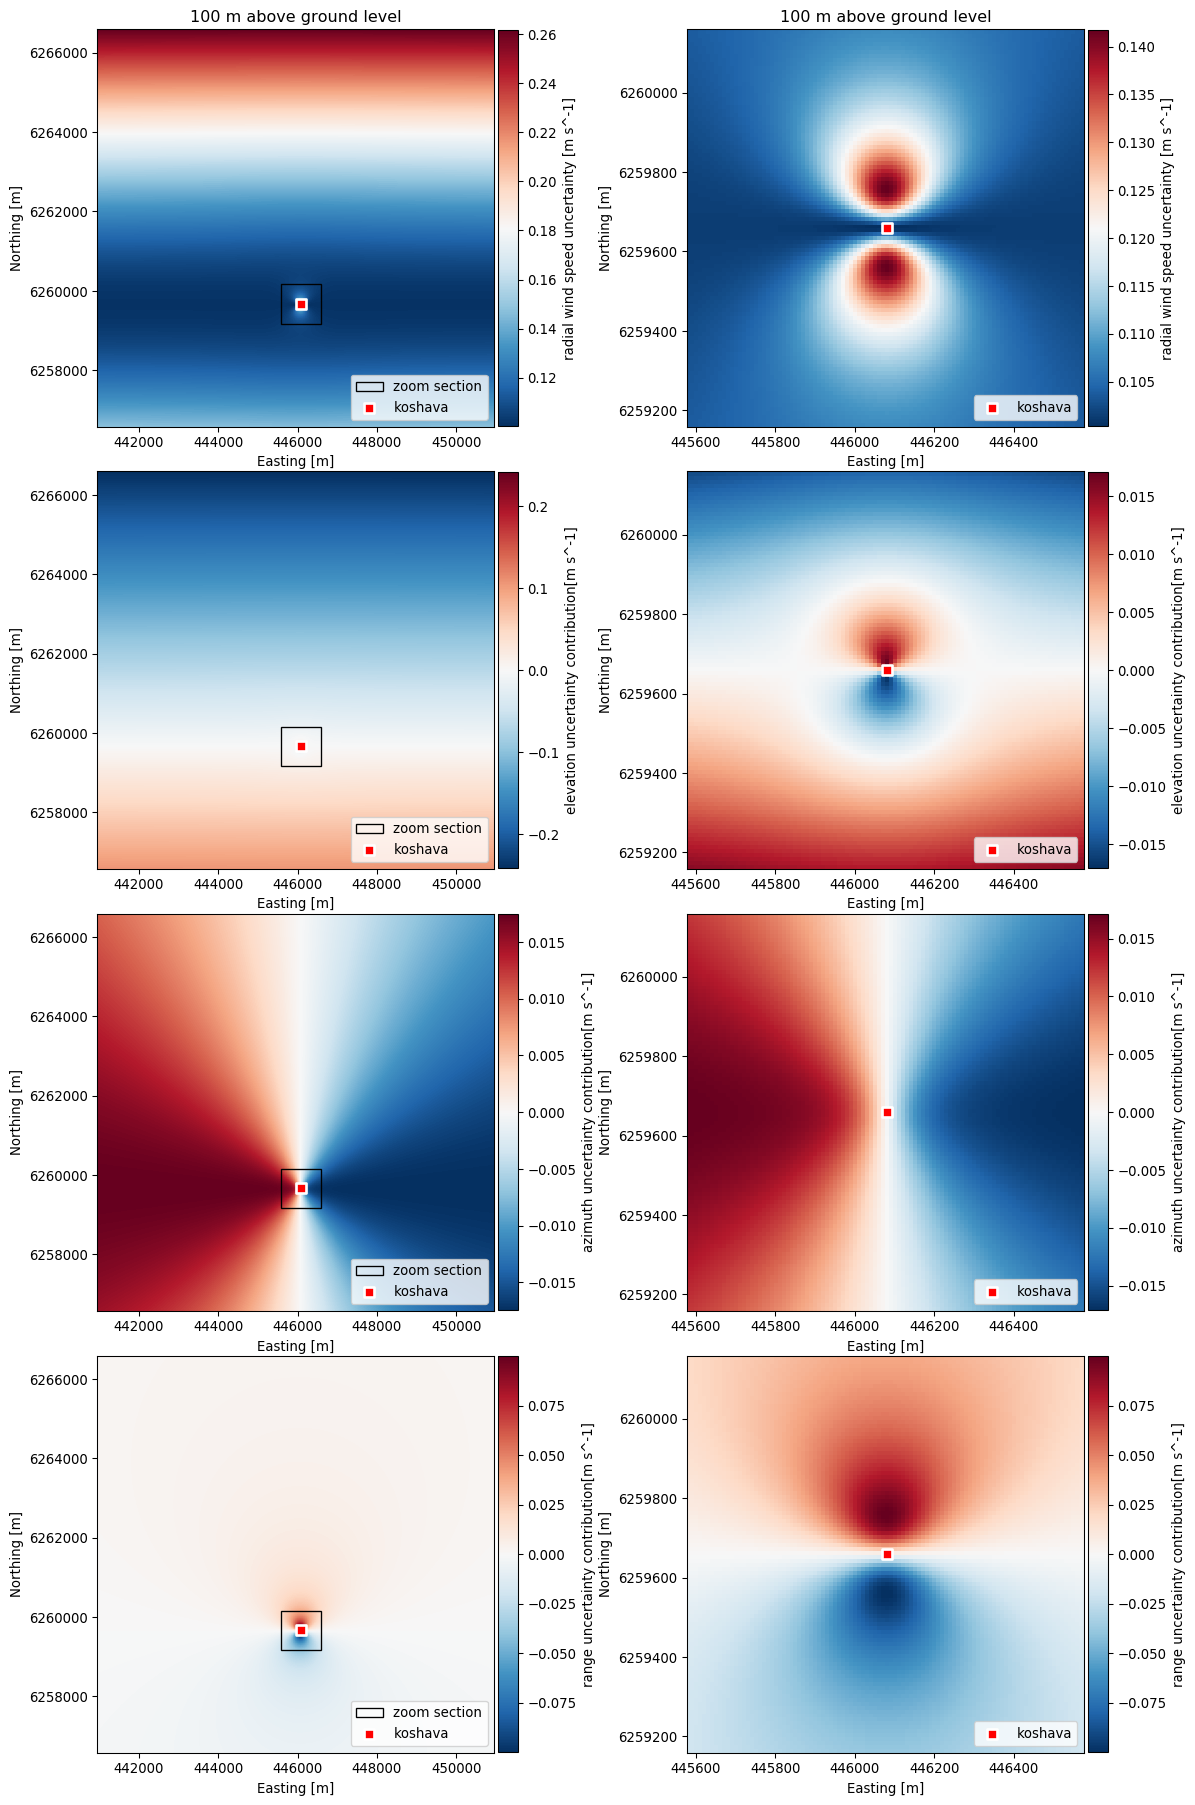

In [10]:
xy_formatter = tic.ScalarFormatter(useOffset=False)
width_px = height_px = 600 # resolution of plots
MY_DPI = 96

lidar_1_pos = lidar_uncertainty.instruments['koshava']['position']

fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(2*width_px/MY_DPI, 4*height_px/MY_DPI), dpi=MY_DPI)


# Radial uncertainty
#
cs = lidar_uncertainty.uncertainty.radial_speed_uncertainty[0].plot(ax=axes[0,0],
                                                                    cmap = plt.cm.RdBu_r, add_colorbar=False)
cbar = plt.colorbar(cs,orientation='vertical', fraction=0.047, pad=0.01,ax=axes[0,0])
cbar.set_label('radial wind speed uncertainty [m s^-1]', fontsize = 10)
axes[0,0].scatter(lidar_1_pos[0], lidar_1_pos[1], 
           marker='s', color='red',edgecolors='white', linewidth='2', s=60,zorder=1000, label = "koshava")
rect = patches.Rectangle((lidar_1_pos[0] - 500, lidar_1_pos[1] - 500),
                         1000,1000,linewidth=1,edgecolor='black',facecolor='none', label = 'zoom section')
axes[0,0].add_patch(rect)
axes[0,0].set_aspect(1.0)
axes[0,0].legend(loc='lower right', fontsize=10)
axes[0,0].set_title('100 m above ground level')


 
cs =lidar_uncertainty.uncertainty.radial_speed_uncertainty[0].sel(Easting=slice(lidar_1_pos[0] - 500, lidar_1_pos[0] + 500), 
                                                              Northing=slice(lidar_1_pos[1] - 500, lidar_1_pos[1] + 500)).plot(ax=axes[0,1], cmap = plt.cm.RdBu_r, add_colorbar=False)
cbar = plt.colorbar(cs,orientation='vertical', fraction=0.047, pad=0.01,ax=axes[0,1])
cbar.set_label('radial wind speed uncertainty [m s^-1]', fontsize = 10)
axes[0,1].scatter(lidar_1_pos[0], lidar_1_pos[1], 
           marker='s', color='red',edgecolors='white', linewidth='2', s=60,zorder=1000, label = "koshava")
axes[0,1].set_aspect(1.0)
axes[0,1].legend(loc='lower right', fontsize=10)
axes[0,1].set_title('100 m above ground level')
axes[0,1].yaxis.set_major_formatter(xy_formatter)
axes[0,1].xaxis.set_major_formatter(xy_formatter)



# Elevation contribution to radial uncertainty
#
cs = lidar_uncertainty.uncertainty.elevation_contribution[0].plot(ax=axes[1,0],
                                                                    cmap = plt.cm.RdBu_r, add_colorbar=False)
cbar = plt.colorbar(cs,orientation='vertical', fraction=0.047, pad=0.01,ax=axes[1,0])
cbar.set_label('elevation uncertainty contribution[m s^-1]', fontsize = 10)
axes[1,0].scatter(lidar_1_pos[0], lidar_1_pos[1], 
           marker='s', color='red',edgecolors='white', linewidth='2', s=60,zorder=1000, label = "koshava")
rect = patches.Rectangle((lidar_1_pos[0] - 500, lidar_1_pos[1] - 500),
                         1000,1000,linewidth=1,edgecolor='black',facecolor='none', label = 'zoom section')
axes[1,0].add_patch(rect)
axes[1,0].set_aspect(1.0)
axes[1,0].legend(loc='lower right', fontsize=10)
axes[1,0].set_title('')


 
cs =lidar_uncertainty.uncertainty.elevation_contribution[0].sel(Easting=slice(lidar_1_pos[0] - 500, lidar_1_pos[0] + 500), 
                                                              Northing=slice(lidar_1_pos[1] - 500, lidar_1_pos[1] + 500)).plot(ax=axes[1,1], cmap = plt.cm.RdBu_r, add_colorbar=False)
cbar = plt.colorbar(cs,orientation='vertical', fraction=0.047, pad=0.01,ax=axes[1,1])
cbar.set_label('elevation uncertainty contribution[m s^-1]', fontsize = 10)
axes[1,1].scatter(lidar_1_pos[0], lidar_1_pos[1], 
           marker='s', color='red',edgecolors='white', linewidth='2', s=60,zorder=1000, label = "koshava")
axes[1,1].set_aspect(1.0)
axes[1,1].legend(loc='lower right', fontsize=10)
axes[1,1].set_title('')
axes[1,1].yaxis.set_major_formatter(xy_formatter)
axes[1,1].xaxis.set_major_formatter(xy_formatter)


# Azimuth contribution to radial uncertainty
#
cs = lidar_uncertainty.uncertainty.azimuth_contribution[0].plot(ax=axes[2,0],
                                                                    cmap = plt.cm.RdBu_r, add_colorbar=False)
cbar = plt.colorbar(cs,orientation='vertical', fraction=0.047, pad=0.01,ax=axes[2,0])
cbar.set_label('azimuth uncertainty contribution[m s^-1]', fontsize = 10)
axes[2,0].scatter(lidar_1_pos[0], lidar_1_pos[1], 
           marker='s', color='red',edgecolors='white', linewidth='2', s=60,zorder=1000, label = "koshava")
rect = patches.Rectangle((lidar_1_pos[0] - 500, lidar_1_pos[1] - 500),
                         1000,1000,linewidth=1,edgecolor='black',facecolor='none', label = 'zoom section')
axes[2,0].add_patch(rect)
axes[2,0].set_aspect(1.0)
axes[2,0].legend(loc='lower right', fontsize=10)
axes[2,0].set_title('')


 
cs =lidar_uncertainty.uncertainty.azimuth_contribution[0].sel(Easting=slice(lidar_1_pos[0] - 500, lidar_1_pos[0] + 500), 
                                                              Northing=slice(lidar_1_pos[1] - 500, lidar_1_pos[1] + 500)).plot(ax=axes[2,1], cmap = plt.cm.RdBu_r, add_colorbar=False)
cbar = plt.colorbar(cs,orientation='vertical', fraction=0.047, pad=0.01,ax=axes[2,1])
cbar.set_label('azimuth uncertainty contribution[m s^-1]', fontsize = 10)
axes[2,1].scatter(lidar_1_pos[0], lidar_1_pos[1], 
           marker='s', color='red',edgecolors='white', linewidth='2', s=60,zorder=1000, label = "koshava")
axes[2,1].set_aspect(1.0)
axes[2,1].legend(loc='lower right', fontsize=10)
axes[2,1].set_title('')
axes[2,1].yaxis.set_major_formatter(xy_formatter)
axes[2,1].xaxis.set_major_formatter(xy_formatter)


# Azimuth contribution to radial uncertainty
#
cs = lidar_uncertainty.uncertainty.range_contribution[0].plot(ax=axes[3,0],
                                                                    cmap = plt.cm.RdBu_r, add_colorbar=False)
cbar = plt.colorbar(cs,orientation='vertical', fraction=0.047, pad=0.01,ax=axes[3,0])
cbar.set_label('range uncertainty contribution[m s^-1]', fontsize = 10)
axes[3,0].scatter(lidar_1_pos[0], lidar_1_pos[1], 
           marker='s', color='red',edgecolors='white', linewidth='2', s=60,zorder=1000, label = "koshava")
rect = patches.Rectangle((lidar_1_pos[0] - 500, lidar_1_pos[1] - 500),
                         1000,1000,linewidth=1,edgecolor='black',facecolor='none', label = 'zoom section')
axes[3,0].add_patch(rect)
axes[3,0].set_aspect(1.0)
axes[3,0].legend(loc='lower right', fontsize=10)
axes[3,0].set_title('')


 
cs =lidar_uncertainty.uncertainty.range_contribution[0].sel(Easting=slice(lidar_1_pos[0] - 500, lidar_1_pos[0] + 500), 
                                                              Northing=slice(lidar_1_pos[1] - 500, lidar_1_pos[1] + 500)).plot(ax=axes[3,1], cmap = plt.cm.RdBu_r, add_colorbar=False)
cbar = plt.colorbar(cs,orientation='vertical', fraction=0.047, pad=0.01,ax=axes[3,1])
cbar.set_label('range uncertainty contribution[m s^-1]', fontsize = 10)
axes[3,1].scatter(lidar_1_pos[0], lidar_1_pos[1], 
           marker='s', color='red',edgecolors='white', linewidth='2', s=60,zorder=1000, label = "koshava")
axes[3,1].set_aspect(1.0)
axes[3,1].legend(loc='lower right', fontsize=10)
axes[3,1].set_title('')
axes[3,1].yaxis.set_major_formatter(xy_formatter)
axes[3,1].xaxis.set_major_formatter(xy_formatter)

plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=-0.55)
plt.show()

#fig.savefig('./grid_plot.png', bbox_inches='tight')

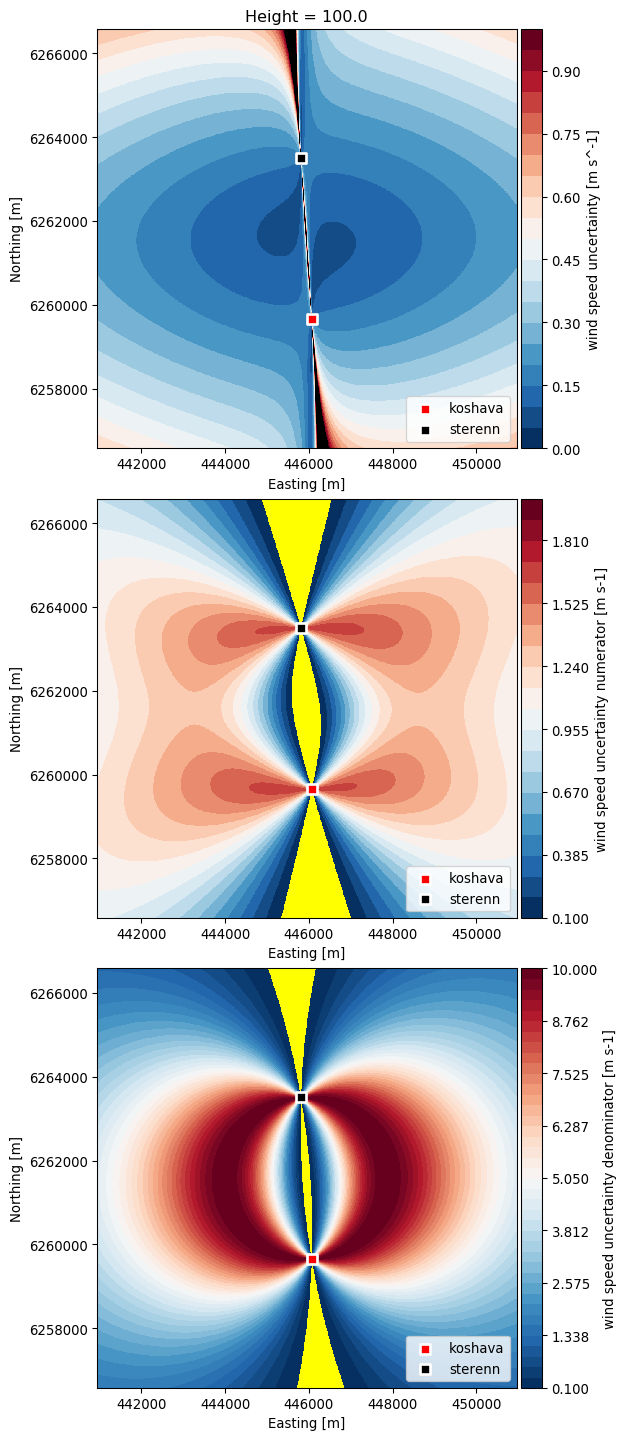

In [11]:
xy_formatter = tic.ScalarFormatter(useOffset=False)
width_px = height_px = 600 # resolution of plots
MY_DPI = 96
fig, axes = plt.subplots(nrows=3, figsize=(width_px/MY_DPI, 3*height_px/MY_DPI), dpi=MY_DPI)

levels = np.linspace(0, 1, 21)
cs = lidar_uncertainty.uncertainty.wind_speed_uncertainty.plot(ax=axes[0],
                                                               cmap = plt.cm.RdBu_r, 
                                                               levels = levels, 
                                                               extend = 'neither', 
                                                               add_colorbar=False)

cs.cmap.set_over('black')
cbar = plt.colorbar(cs,orientation='vertical', fraction=0.047, pad=0.01,  ax=axes[0])
cbar.set_label('wind speed uncertainty [m s^-1]', fontsize = 10)


axes[0].scatter(lidar_uncertainty.instruments['koshava']['position'][0], 
           lidar_uncertainty.instruments['koshava']['position'][1], 
           marker='s', color='red',edgecolors='white', linewidth='2', 
           s=60,zorder=1000, label = "koshava")

axes[0].scatter(lidar_uncertainty.instruments['sterenn']['position'][0], 
           lidar_uncertainty.instruments['sterenn']['position'][1],
           marker='s', color='black', edgecolors='white', linewidth='2', 
           s=60,zorder=1000, label = "sterenn")
axes[0].set_aspect(1.0)
axes[0].legend(loc='lower right', fontsize=10)



##
levels = np.linspace(0.1, 2, 21)
cs = lidar_uncertainty.uncertainty.numerator_of_wind_speed_uncertainty.plot(ax=axes[1],
                                                                           cmap = plt.cm.RdBu_r, 
                                                                           levels = levels, 
                                                                           extend = 'neither', 
                                                                           add_colorbar=False)

cs.cmap.set_over('black')
cs.cmap.set_under('yellow')
cbar = plt.colorbar(cs,orientation='vertical', fraction=0.047, pad=0.01,ax=axes[1])
cbar.set_label('wind speed uncertainty numerator [m s-1]', fontsize = 10)
axes[1].scatter(lidar_uncertainty.instruments['koshava']['position'][0], 
           lidar_uncertainty.instruments['koshava']['position'][1], 
           marker='s', color='red',edgecolors='white', linewidth='2', 
           s=60,zorder=1000, label = "koshava")

axes[1].scatter(lidar_uncertainty.instruments['sterenn']['position'][0], 
           lidar_uncertainty.instruments['sterenn']['position'][1],
           marker='s', color='black', edgecolors='white', linewidth='2', 
           s=60,zorder=1000, label = "sterenn")
axes[1].set_aspect(1.0)
axes[1].legend(loc='lower right', fontsize=10)
axes[1].set_title('')



###
levels = np.linspace(0.1, 10, 41)
cs = lidar_uncertainty.uncertainty.denominator_of_wind_speed_uncertainty.plot(ax=axes[2],cmap = plt.cm.RdBu_r, levels = levels, 
                                                                   extend = 'neither', 
                                                                   add_colorbar=False)
axes[2].set_title('')
cs.cmap.set_over('black')
cs.cmap.set_under('yellow')
cbar = plt.colorbar(cs,orientation='vertical', fraction=0.047, pad=0.01,ax=axes[2])
cbar.set_label(r'wind speed uncertainty denominator [m s-1]', fontsize = 10)
axes[2].scatter(lidar_uncertainty.instruments['koshava']['position'][0], 
           lidar_uncertainty.instruments['koshava']['position'][1], 
           marker='s', color='red',edgecolors='white', linewidth='2', 
           s=60,zorder=1000, label = "koshava")

axes[2].scatter(lidar_uncertainty.instruments['sterenn']['position'][0], 
           lidar_uncertainty.instruments['sterenn']['position'][1],
           marker='s', color='black', edgecolors='white', linewidth='2', 
           s=60,zorder=1000, label = "sterenn")
axes[2].set_title('')
axes[2].set_aspect(1.0)
axes[2].legend(loc='lower right', fontsize=10)



plt.subplots_adjust(wspace = 0, hspace = 0.12)
plt.show()

#fig.savefig('./something.png', bbox_inches='tight')

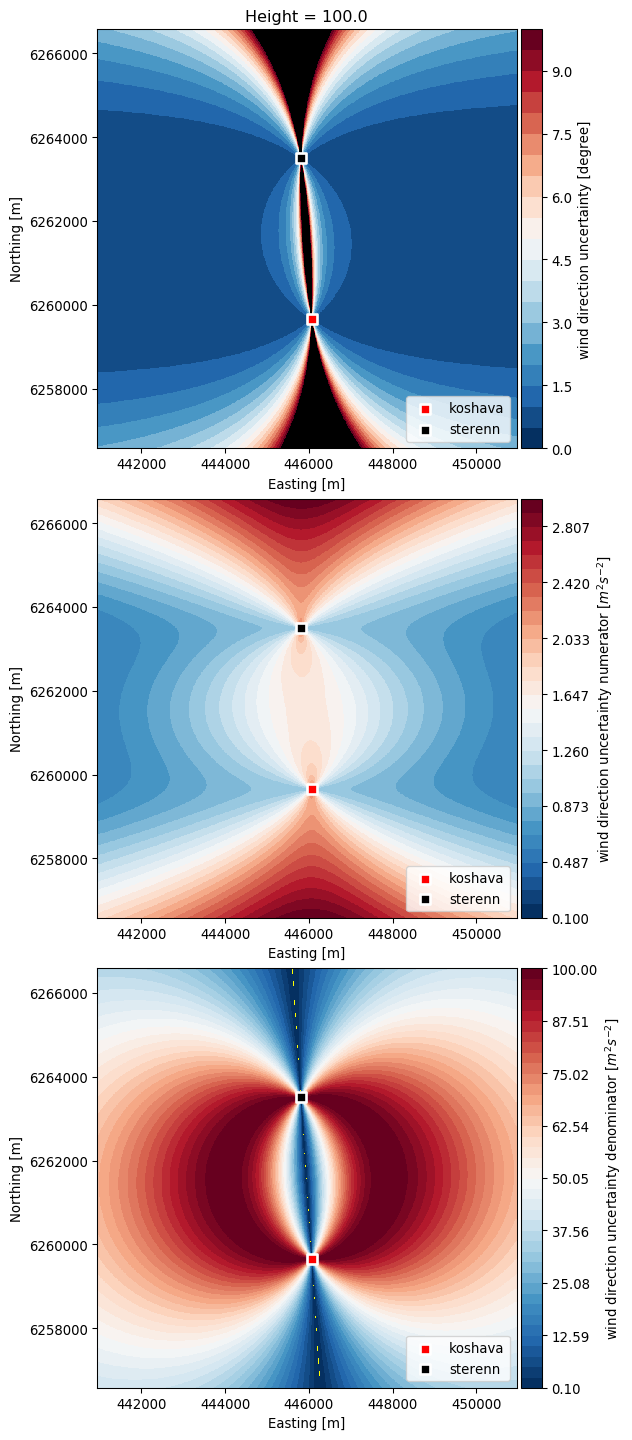

In [12]:
fig, axes = plt.subplots(nrows=3, figsize=(width_px/MY_DPI, 3*height_px/MY_DPI), dpi=MY_DPI)

levels = np.linspace(0, 10, 21)
cs = lidar_uncertainty.uncertainty.wind_from_direction_uncertainty.plot(ax=axes[0],
                                                               cmap = plt.cm.RdBu_r, 
                                                               levels = levels, 
                                                               extend = 'neither', 
                                                               add_colorbar=False)

cs.cmap.set_over('black')
cbar = plt.colorbar(cs,orientation='vertical', fraction=0.047, pad=0.01,  ax=axes[0])
cbar.set_label('wind direction uncertainty [degree]', fontsize = 10)


axes[0].scatter(lidar_uncertainty.instruments['koshava']['position'][0], 
           lidar_uncertainty.instruments['koshava']['position'][1], 
           marker='s', color='red',edgecolors='white', linewidth='2', 
           s=60,zorder=1000, label = "koshava")

axes[0].scatter(lidar_uncertainty.instruments['sterenn']['position'][0], 
           lidar_uncertainty.instruments['sterenn']['position'][1],
           marker='s', color='black', edgecolors='white', linewidth='2', 
           s=60,zorder=1000, label = "sterenn")
axes[0].set_aspect(1.0)
axes[0].legend(loc='lower right', fontsize=10)



##
levels = np.linspace(0.1, 3, 31)
cs = lidar_uncertainty.uncertainty.numerator_of_wind_from_direction_uncertainty.plot(ax=axes[1],
                                                                                       cmap = plt.cm.RdBu_r, 
                                                                                       levels = levels, 
                                                                                       extend = 'neither', 
                                                                                       add_colorbar=False)


cs.cmap.set_over('black')
cs.cmap.set_under('yellow')
cbar = plt.colorbar(cs,orientation='vertical', fraction=0.047, pad=0.01,ax=axes[1])
cbar.set_label(r'wind direction uncertainty numerator [$m^{2} s^{-2}$]', fontsize = 10)
axes[1].scatter(lidar_uncertainty.instruments['koshava']['position'][0], 
           lidar_uncertainty.instruments['koshava']['position'][1], 
           marker='s', color='red',edgecolors='white', linewidth='2', 
           s=60,zorder=1000, label = "koshava")

axes[1].scatter(lidar_uncertainty.instruments['sterenn']['position'][0], 
           lidar_uncertainty.instruments['sterenn']['position'][1],
           marker='s', color='black', edgecolors='white', linewidth='2', 
           s=60,zorder=1000, label = "sterenn")
axes[1].set_aspect(1.0)
axes[1].legend(loc='lower right', fontsize=10)
axes[1].set_title('')


###
levels = np.linspace(0.1, 100, 41)
cs = lidar_uncertainty.uncertainty.denominator_of_wind_from_direction_uncertainty.plot(ax=axes[2],
                                                                                       cmap = plt.cm.RdBu_r, 
                                                                                       levels = levels, 
                                                                                       extend = 'neither', 
                                                                                       add_colorbar=False)
axes[2].set_title('')
cs.cmap.set_over('black')
cs.cmap.set_under('yellow')
cbar = plt.colorbar(cs,orientation='vertical', fraction=0.047, pad=0.01,ax=axes[2])
cbar.set_label(r'wind direction uncertainty denominator [$m^{2} s^{-2}$]', fontsize = 10)
axes[2].scatter(lidar_uncertainty.instruments['koshava']['position'][0], 
           lidar_uncertainty.instruments['koshava']['position'][1], 
           marker='s', color='red',edgecolors='white', linewidth='2', 
           s=60,zorder=1000, label = "koshava")

axes[2].scatter(lidar_uncertainty.instruments['sterenn']['position'][0], 
           lidar_uncertainty.instruments['sterenn']['position'][1],
           marker='s', color='black', edgecolors='white', linewidth='2', 
           s=60,zorder=1000, label = "sterenn")
axes[2].set_title('')
axes[2].set_aspect(1.0)
axes[2].legend(loc='lower right', fontsize=10)






plt.subplots_adjust(wspace = 0, hspace = 0.12)
plt.show()

In [13]:
# Deriving histogram of wind speed and wind direction uncertainty
# with respect to the minimum between beam angle


histogram_data_speed = np.array([lidar_uncertainty.uncertainty.between_beam_angle.values.reshape(-1), 
                                 lidar_uncertainty.uncertainty.wind_speed_uncertainty.values.reshape(-1)]).T

histogram_data_direction = np.array([lidar_uncertainty.uncertainty.between_beam_angle.values.reshape(-1), 
                                     lidar_uncertainty.uncertainty.wind_from_direction_uncertainty.values.reshape(-1)]).T

Minimum between-beam angle: 20˚
Mean: 0.28 m/s
Max: 0.66 m/s
Min: 0.09 m/s
Standard deviation: 0.12 m/s


Minimum between-beam angle: 30˚
Mean: 0.23 m/s
Max: 0.44 m/s
Min: 0.09 m/s
Standard deviation: 0.08 m/s


Minimum between-beam angle: 40˚
Mean: 0.2 m/s
Max: 0.31 m/s
Min: 0.09 m/s
Standard deviation: 0.05 m/s




<function matplotlib.pyplot.show(*args, **kw)>

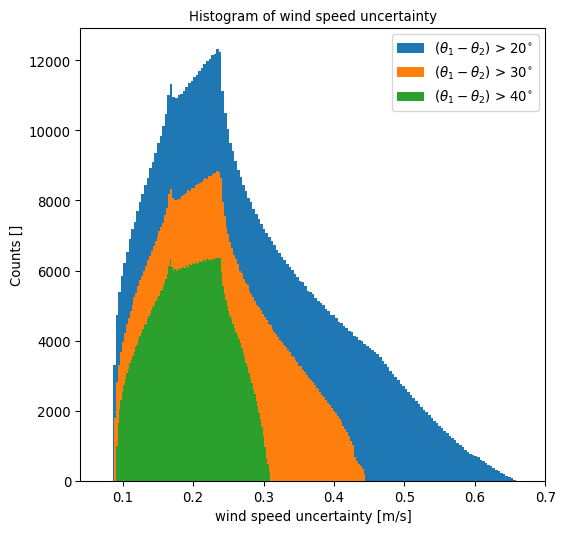

In [14]:
fix, ax =  plt.subplots(figsize=(width_px/MY_DPI, height_px/MY_DPI), dpi=MY_DPI)

for min_angle in range(20,50,10):
    indexes = np.where(histogram_data_speed[:,0] > min_angle)
    print('Minimum between-beam angle: ' + str(min_angle) + '˚')
    print('Mean: ' + str(np.round(np.mean(histogram_data_speed[indexes][:,1]),2)) + ' m/s')
    print('Max: ' + str(np.round(np.max(histogram_data_speed[indexes][:,1]),2))+ ' m/s')    
    print('Min: ' + str(np.round(np.min(histogram_data_speed[indexes][:,1]),2))+ ' m/s')        
    print('Standard deviation: ' + str(np.round(np.std(histogram_data_speed[indexes][:,1]),2))+ ' m/s')
    print('\n')

    plt.hist((histogram_data_speed[indexes][:,1]),  
             bins='auto', label = r"$(\theta_{1} - \theta_{2})$ > " + str(min_angle) + r"$^{\circ}$")

ax.legend(loc='upper right', fontsize=10)
plt.title('Histogram of wind speed uncertainty', fontsize = 10)
plt.xlabel('wind speed uncertainty [m/s]', fontsize = 10)
plt.ylabel('Counts []', fontsize = 10)

plt.xlim(0.04, 0.7)

plt.show

Minimum between-beam angle: 20˚
Mean: 0.28˚
Max: 0.66˚
Min: 0.09˚
Standard deviation: 0.12˚


Minimum between-beam angle: 30˚
Mean: 0.23˚
Max: 0.44˚
Min: 0.09˚
Standard deviation: 0.08˚


Minimum between-beam angle: 40˚
Mean: 0.2˚
Max: 0.31˚
Min: 0.09˚
Standard deviation: 0.05˚




<function matplotlib.pyplot.show(*args, **kw)>

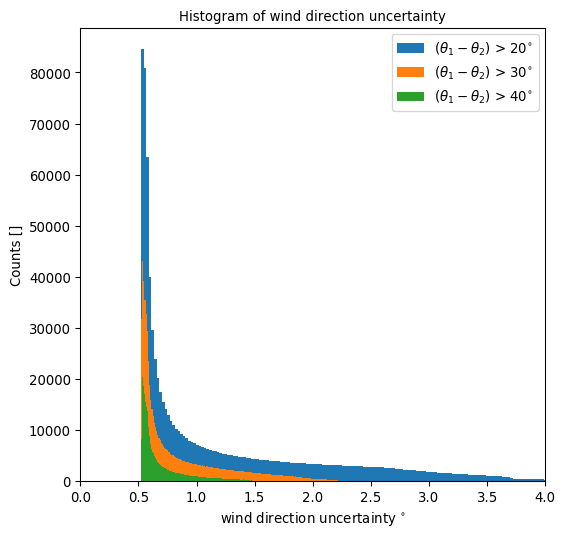

In [15]:


fix, ax =  plt.subplots(figsize=(width_px/MY_DPI, height_px/MY_DPI), dpi=MY_DPI)

for min_angle in range(20,50,10):
    indexes = np.where(histogram_data_direction[:,0] > min_angle)
    print('Minimum between-beam angle: ' + str(min_angle) + '˚')
    print('Mean: ' + str(np.round(np.mean(histogram_data_speed[indexes][:,1]),2)) + '˚')
    print('Max: ' + str(np.round(np.max(histogram_data_speed[indexes][:,1]),2))+ '˚')
    print('Min: ' + str(np.round(np.min(histogram_data_speed[indexes][:,1]),2))+ '˚')
    print('Standard deviation: ' + str(np.round(np.std(histogram_data_speed[indexes][:,1]),2))+ '˚')
    print('\n')

    plt.hist((histogram_data_direction[indexes][:,1]),  
             bins='auto', label = r"$(\theta_{1} - \theta_{2})$ > " + str(min_angle) + r"$^{\circ}$")

ax.legend(loc='upper right', fontsize=10)
plt.title('Histogram of wind direction uncertainty', fontsize = 10)
plt.xlabel(r'wind direction uncertainty $^{\circ}$', fontsize = 10)
plt.ylabel('Counts []', fontsize = 10)

plt.xlim(0, 4)

plt.show